# Wait Wait, Don't Analyze Me!

![NPR logo](https://media.npr.org/branding/programs/wait-wait-dont-tell-me/branding_main-c5920a167d6a5d445ce86fac30b90454223b6b57.png "One nerd's attempt to learn everything there is to know about NPR's greatest quiz show.")


# Introduction
[Wait Wait, Don't Tell Me!](https://www.npr.org/programs/wait-wait-dont-tell-me/) is NPR's longest-running news quiz show. Contestents call in to answer questions about the week's news, and a rotating cast of three panelists make jokes and parody newsworthy (and not-so-newsworthy) current events. Listening to "Wait wait" has been a highlight of my week since I was a kid, and it remains one of NPR's most popular segments. So what better way to show my appreciation than to take it apart and see what makes it tick?

For this project, I have pulled text transcripts of each episode of "Wait, Wait", storing them as a MySQL library. I have two goals:
1. Understand and predict jokes in the program.
2. Create a "Wait wait" transcript generator, so that I don't have to wait a whole week between episodes!

# Section 0: Initial data exploration

## 0.1 Loading the data
Before I can analyze the data, I must first load it and process it. To accomplish this, I wrote a simple function to load in text files containing the transcripts, figure out who the speakers are, and separate the text blocks into a list of words.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import keras
import mysql.connector
import re

%matplotlib inline

# change the default font size in figures to be larger
font = {'size'   : 15}

plt.rc('font', **font)

Using TensorFlow backend.


In [2]:
# connect to the database of wait wait don't tell me transcripts
cnx = mysql.connector.connect(database='wait_wait',
                              user='root')

In [3]:
# function to pull some transcripts from the database
def pull_transcript(n=5):
    # instantiate a cursor to select data from the database
    curs = cnx.cursor()
    curs.execute(f'select * from transcripts limit {n}')
    
    # pull the data and convert to a pandas dataframe
    df = pd.DataFrame(data = np.array(curs.fetchmany(n)),columns=curs.column_names)
    df = df.set_index('id')
    
    # close the cursor
    curs.close()
    return df

In [78]:
transcript_df = pull_transcript(n=3000)
transcript_df.tail()

,episode_id,aired_at,url,segment,transcript
id,,,,,
2996,404,2012-09-08,https://www.npr.org/templates/transcript/trans...,panel,\n \n \n \n\n BILL KURTIS: Fro...
2997,404,2012-09-08,https://www.npr.org/templates/transcript/trans...,limerick,"\n \n \n \n\n PETER SAGAL, HOS..."
2998,404,2012-09-08,https://www.npr.org/templates/transcript/trans...,lightning,"\n \n \n \n\n PETER SAGAL, HOS..."
2999,404,2012-09-08,https://www.npr.org/templates/transcript/trans...,predictions,"\n \n \n \n\n PETER SAGAL, HOS..."
3000,405,2012-09-01,https://www.npr.org/templates/transcript/trans...,job,\n \n \n \n\n CARL KASELL: Fro...


## 0.2 Example transcript

Let's print a little bit of the transcript from the first dataset, and see what it looks like.

In [6]:
print(transcript_df.loc[1,'transcript'][:500])


    
        
    

    BILL KURTIS: From NPR and WBEZ Chicago, this is WAIT WAIT... DON'T TELL ME, the NPR news quiz. Hey, Arthur Miller - step into this Cruci-Bill (ph).
    (LAUGHTER)
    KURTIS: I'm Bill Kurtis. And here's your host at the Chase Bank Auditorium in downtown Chicago, Peter Sagal.
    PETER SAGAL, HOST: 
    Thank you, Bill. Thank you, everybody.
    (CHEERING)
    SAGAL: Thank you so much. We have a very interesting show for you today. Later on, we're going to be talking to M


In [7]:
transcript_df.loc[1,'transcript'][:1000]

"\n    \n        \n    \n\n    BILL KURTIS: From NPR and WBEZ Chicago, this is WAIT WAIT... DON'T TELL ME, the NPR news quiz. Hey, Arthur Miller - step into this Cruci-Bill (ph).\n    (LAUGHTER)\n    KURTIS: I'm Bill Kurtis. And here's your host at the Chase Bank Auditorium in downtown Chicago, Peter Sagal.\n    PETER SAGAL, HOST: \n    Thank you, Bill. Thank you, everybody.\n    (CHEERING)\n    SAGAL: Thank you so much. We have a very interesting show for you today. Later on, we're going to be talking to Microsoft co-founder Steve Ballmer. He is, we believe, the richest guest we've ever had. But, of course, your true wealth is measured in your friends. And this just in - he has more friends, too.\n    (LAUGHTER)\n    SAGAL: But first, as many of you know, the NPR podcast feeds got all screwed up last week. People who tried to download our show got, for example, How I Built This instead, for which I apologize. And the people who wanted How I Built This got us, for which I apologize eve

Initially, we can note a number of features. First, audience responses are noted with the '(LAUGHTER)' marker and '(APPLAUSE)' marker. This will prove very useful, as we have an automatic metric for "funniness" of the preceding text. 

Speakers' names are in all caps, followed by a colon. Speakers are also separated by a line break and a tab, which could potentially be used to segment the text into phrases by various people. 

It's probably worth doing a little more processing on these lines, dividing them by speaker, and giving them a marker for applause and laughter if they are followed by applause or laughter. 

In [8]:
def line_info(transcript_number):
    transcript = transcript_df.loc[transcript_number,'transcript'];
    by_lines = transcript.split('\n    ')
    df = pd.DataFrame(by_lines,columns=['lines']) # turn the lines into a dataframe
    
    # if the line contains "APPLAUSE", mark the previous line as "clapping"
    # if the line contains "LAUGHTER", mark the previous line as "funny"
    df['funny'] = False
    df['clapping'] = False
    df.loc[np.where(df.lines=='(LAUGHTER)')[0]-1,'funny'] = True
    df.loc[np.where(df.lines=='(APPLAUSE)')[0]-1,'clapping'] = True
    df.loc[np.where(df.lines=='(CLAPPING)')[0]-1,'clapping'] = True
    df.loc[np.where(df.lines=='(CHEERING)')[0]-1,'clapping'] = True
    
    # for the remaining lines, identify the speaker using regular expressions
    df['speaker'] = ''
    speaker_re = re.compile('[A-Z]+:'); # all-caps word followed by a colon
    full_speaker_re = re.compile('^(.*?)[A-Z]+: ') # all-caps word followed by a colon, and all words preceding
    for idx,line in zip(df.index,df.lines):
        try:
            df.loc[idx,'speaker'] = speaker_re.search(line).group()[:-1]
            df.loc[idx,'lines'] = full_speaker_re.sub('',line)
            
            if df.loc[idx,'speaker'] == 'HOST':
                df.loc[idx+1,'speaker'] = 'SAGAL'
                df.loc[idx,'speaker'] = ''
            elif df.loc[idx,'speaker'] == 'JR': # sometimes mis-names Roy Blount, Jr.
                df.loc[idx,'BLOUNT']
        except: # skip this if the line doesn't contain a word in the right format to be a speaker
            continue
    
    # drop the lines with no speaker (Applause markers, empty lines, etc.)
    rows_to_remove = df.index[np.where((df.speaker==''))[0]]
    df = df.drop(rows_to_remove)
    
    return df

# calculates the line info dataframe for each transcript in the list, and combines the dataframes
def line_info_multiples(transcript_list):
    dataframe_list = []
    for t in transcript_list:
        dataframe_list.append(line_info(t))
        
        

In [9]:
# show an example processed transcript
transcript = line_info(1)
transcript.head()

,lines,funny,clapping,speaker
4,"From NPR and WBEZ Chicago, this is WAIT WAIT.....",True,False,KURTIS
6,I'm Bill Kurtis. And here's your host at the C...,False,False,KURTIS
8,"Thank you, Bill. Thank you, everybody.",False,True,SAGAL
10,Thank you so much. We have a very interesting ...,True,False,SAGAL
12,"But first, as many of you know, the NPR podcas...",True,False,SAGAL


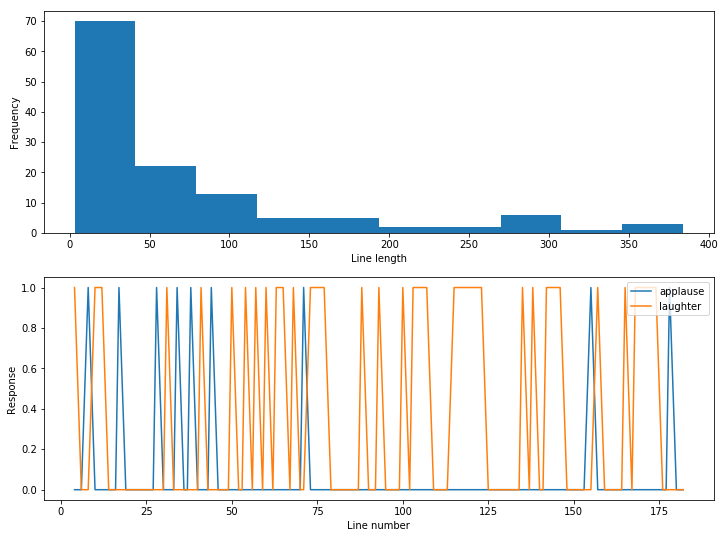

In [10]:
plt.figure(figsize=(12,9))
plt.subplot(2,1,1);
plt.hist(transcript.lines.str.len());
plt.xlabel('Line length')
plt.ylabel('Frequency')

plt.subplot(2,1,2);
plt.plot(transcript.clapping)
plt.plot(transcript.funny);
plt.xlabel('Line number')
plt.ylabel('Response')
plt.legend(['applause','laughter'],loc='upper right')

## 0.3 Word cloud
Just for fun, let's make a "word cloud" - this is a visualization tool that makes a pretty picture, with word sizes based on their frequency in the text. I based the formatting on this on the excellent tutorial by Max Woolf, posted [here](https://minimaxir.com/2016/05/wordclouds/). I'll make the picture in shades of orange, and in the shape of an exclamation point, in line with the logo of Wait Wait.

In [14]:
from wordcloud import WordCloud, STOPWORDS
import string
from palettable.colorbrewer.sequential import Oranges_9
import random
from PIL import Image

def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return tuple(Oranges_9.colors[random.randint(3,8)])

font_path = './Fonts/FrederickatheGreat-Regular.ttf' # font from google fonts: https://fonts.google.com/?selection.family=Fredericka+the+Great

In [21]:
# concatenate the text from all of the transcripts
text = transcript_df.transcript.str.cat()

# convert everything to upper case so we don't get repeat counts
text = text.upper()

# remove the footer text at the bottom of each transcript
copyright_text = text[-475:]
stopwords = set(STOPWORDS)
stopwords = stopwords.union(set(copyright_text.split()))

In [37]:
# load the image mask: exclamation inside a circle from fontawesome
icon_path = './exclamation-sign.png'
icon = Image.open(icon_path)
icon = np.array(icon)

In [33]:
icon = icon[::4,::4,:]

In [38]:
icon.shape

(512, 512, 3)

In [39]:
# generate the word cloud
wc = WordCloud(background_color="white", 
               font_path=font_path,
               collocations=False,
               max_words=1000,
               max_font_size=240, 
               random_state=42,
               mask=icon,
               stopwords=stopwords,
               color_func=color_func)
               
# generate word cloud
wc.generate_from_text(text.upper());

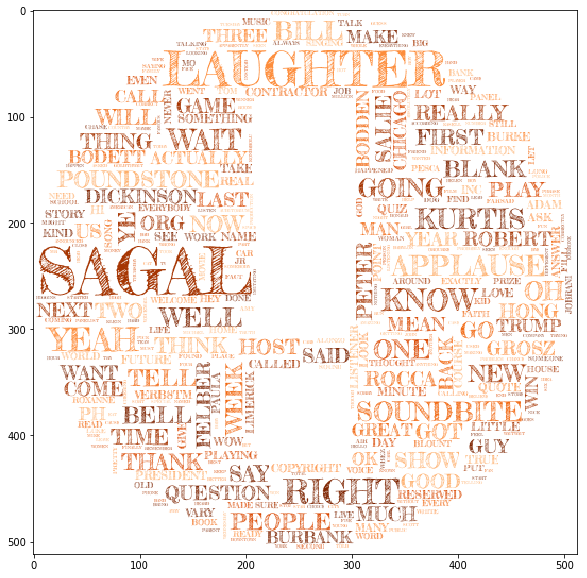

In [40]:
# plot the cloud
plt.figure(figsize=(10,10));
plt.imshow(wc);

# uncomment this to save the image
# wc.to_file("WaitWaitCloud-big.png");

# Section 1: Understanding jokes

### 1.1 Who is the funniest panelist? 

The first question I address is which panelist is the funniest. I'm aided in this process by the fact that laughter is marked in the transcripts, with the label "(LAUGHTER)". Thus, I can look at every laugh, and figure out who caused it. But people who talk more are likely to get more laughs than those who don't talk much, on average. So, I will calculate the "**Laugh rate**," defined as the number of laughs each speaker gets per statement. It can also be the probability of laughter, given something the panelist said. I will save my results in a pandas table.

In [79]:
# generate an empty pandas dataframe to keep track of the results
df = pd.DataFrame(index=[], columns=['num_lines','num_segments','num_laughs','num_claps'])
df = df.fillna(0)

# for each transcript, count the words spoken and the number of laughs
for ID in transcript_df.index:
    transcript = line_info(ID)
    
    # increment the number of segments this person has been seen in
    for speaker in set(transcript.speaker):
        if speaker not in df.index: # add a row if we haven't seen this speaker before
            df.loc[speaker,:] = 0
        df.loc[speaker,'num_segments'] +=1
        continue
    
    # Count the number of laughs each speaker receives
    funny_counts = transcript.loc[transcript['funny'],'speaker'].value_counts()
    df.loc[funny_counts.index,'num_laughs'] +=funny_counts
    
    # Count the number of claps each speaker receives
    clap_counts = transcript.loc[transcript['clapping'],'speaker'].value_counts()
    
    df.loc[funny_counts.index,'num_claps'] +=clap_counts
    
    # Count the number of lines per speaker
    line_counts = transcript.loc[:,'speaker'].value_counts()
    df.loc[line_counts.index,'num_lines'] += line_counts
        
    # report progress
    if ID % 250 == 0:
        print(ID)

250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000


In [80]:
df.describe() # some summary statistics on the data

,num_lines,num_segments,num_laughs,num_claps
count,1671.000000,1671.000000,1671.000000,1158.000000
mean,123.223818,10.543986,25.560742,0.695164
std,2418.016219,100.591736,545.766375,1.871266
min,1.000000,1.000000,0.000000,0.000000
25%,2.000000,1.000000,0.000000,0.000000
50%,11.000000,1.000000,0.000000,0.000000
75%,27.000000,2.000000,2.000000,0.000000
max,97591.000000,2998.000000,22055.000000,20.000000


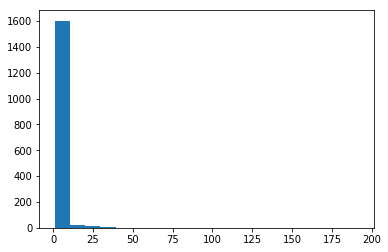

In [82]:
plt.hist(df.num_segments[df.num_segments <200],bins=20);

We should do some data cleanup at this juncture. In particular, there are may speakers with very few words, or who appear on a single segment. This is because each "call in" gets assigned to a particular speaker. Each show also has a guest speaker, who typically only appears on the "not my job segment. So let's go ahead and remove entries where the speaker appears in under 5 segments, or speaks very few words.

In [85]:
# remove the speakers with less than 2000 words (call-in guests and the like)
df = df[df['num_segments'] > 50]
# df = df[df['num_lines'] > 50]

In [86]:
# Now divide the number of laughs by the number of words to get the laugh rate (laughs per hundred words)
df['laughs_per_line'] = df['num_laughs']/df['num_lines']
df['laughs_per_segment'] = df['num_laughs']/df['num_segments']
df['clap_rate'] = df['num_claps']/df['num_lines']
df.sort_values('laughs_per_line',ascending=False)

,num_lines,num_segments,num_laughs,num_claps,laughs_per_line,laughs_per_segment,clap_rate
GOLDTHWAIT,1139.0,146.0,389.0,NaN,0.341528,2.664384,NaN
KONDABOLU,356.0,56.0,117.0,NaN,0.328652,2.089286,NaN
JR,373.0,78.0,121.0,NaN,0.324397,1.551282,NaN
BURKE,1322.0,218.0,400.0,NaN,0.302572,1.834862,NaN
POUNDSTONE,7704.0,842.0,2214.0,NaN,0.287383,2.629454,NaN
BODDEN,2345.0,416.0,617.0,NaN,0.263113,1.483173,NaN
FARSAD,674.0,99.0,175.0,NaN,0.259644,1.767677,NaN
BURBANK,2711.0,464.0,689.0,NaN,0.254150,1.484914,NaN
KLEIN,1303.0,156.0,329.0,NaN,0.252494,2.108974,NaN
BABYLON,2916.0,400.0,733.0,NaN,0.251372,1.832500,NaN


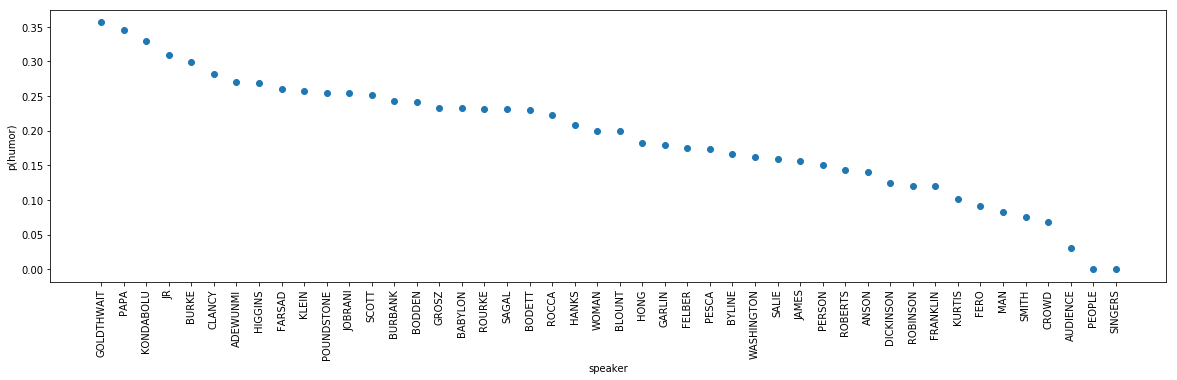

In [76]:
plt.figure(figsize=(20,5));
plt.plot(df.sort_values('laughs_per_line',ascending=False).laughs_per_line,'o');
plt.xlabel('speaker');
plt.xticks(rotation=90)
plt.ylabel('p(humor)');

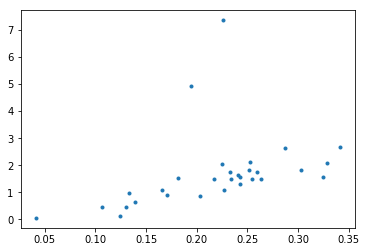

In [87]:
plt.plot(df.laughs_per_line,df.laughs_per_segment,'.')

### Conclusions, further questions
It looks like our answer to "Who is the funniest panelist?" is Bobcat Goldthwait, followed by whoever Papa is and Hari Kondabolu. There are definitely some limitations to this analysis - first, if any of the speakers happened to have the same last name, they would be counted as the same "person." Second, some speakers are occasionally referred to differenty. For example, Roy Blount Jr usually sometimes is labeled Jr (speaker name is assigned to the last word in their name), and sometimes as Blount. Still, no panelist has the same last name as another panelist, and non-panelist speakers tend to have very few lines, so this is unlikely to bias the data too strongly. I think Roy Blount Jr is the only panelist with the "name confusion" issue, so this could probably be manually corrected.

### Questions to address:
1. What are the funniest words? 
    - Examine the words that precede laughs, look for trends.
    - Weight by word frequency in whole show. (percent of time the word elicited a laugh)
    - Eliminate "common" words (the, and, ...)
2. What properties predict whether a line will be funny?
    - Speaker identity
    - Whether the previous line was funny
    - Length of the line
    - Words contained in the line
    - Position of the line in the transcript (beginning, middle, end)
    - Segment identity (limericks, who's bill this time, etc)
3. Build a laugh predictor:
    - Based on a set of words
    - RNN
    - Markov model?

### 1.2 Predicting humor based on line statistics

In our quest to predict laughter, one reasonable thing to consider is which words or phrases tend to precede laughs. Are there any major trends in these words? To do this, I will count all of the words that precede laughter, and compare it with total word counts.

In [97]:
# Long lines are often funny, so let's calculate that value
transcript['line_length'] = transcript.lines.str.len()

# We want to convert speaker to categorical

In [ ]:
# start out by processing one transcript
transcript_df.loc[1,'transcript']

In [ ]:
def transcriptToFreqDict(transcript):
    wordlist = transcript.split()
    wordfreq = [wordlist.count(p) for p in wordlist]
    return dict(zip(wordlist,wordfreq))

In [ ]:
transcriptToFreqDict(transcript_df.loc[1,'transcript'])

# How is laughter distributed through a show?

In [ ]:
plt.figure(figsize=(10,20))
for file_idx,file in zip(range(len(files)),files):
    words, names,transcript = Load_Transcript(data_dir+file)
    
    # note where in the transcript laughs occured
    laughs = np.zeros(len(words))
    speaker_change = np.zeros(len(words))
    for word_idx, word in zip(range(len(words)), words):
        if 'LAUGHTER' in word:
            laughs[word_idx] = 1
    plt.subplot(20,1,file_idx+1)
    plt.plot(np.convolve(laughs,np.ones(100),mode='same'))
    plt.xlim([0,2000])
    plt.ylim([0, 6.5])
    plt.text(1900,5,file,ha='right')

plt.xlabel('Word in transcript');
plt.ylabel('Laugh rate (laughs per hundred words)');

# Can we create our own Wait Wait Don't Tell Me content?

In [ ]:
# Load all of the transcripts
transcript_list = []
chars = set()
for file in files:
    _,_,transcript = Load_Transcript(data_dir+file)
    transcript_list.append(transcript)


In [ ]:
# build a tokenizer to convert the words to integers
vocab_size = 10000
tokenizer = keras.preprocessing.text.Tokenizer(num_words=vocab_size, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',split=' ')
tokenizer.fit_on_texts(transcript_list)
encoded_transcripts = tokenizer.texts_to_sequences(transcript_list)

In [ ]:
help(tokenizer.sequences_to_texts)

In [ ]:
tokenizer.sequences_to_texts([encoded_transcripts[1]])

In [ ]:
# split up the model
train_len = 50
x = []
y = []
for transcript in encoded_transcripts:
    for word in range(0,len(transcript)-train_len-1,3):
        x.append(transcript[word:word+train_len])
        y.append(transcript[word+train_len+1])
x = np.array(x)
y = np.array(y)

from keras.utils import to_categorical
y_binary = to_categorical(y,num_classes=vocab_size)

In [ ]:
# build the model
model = keras.Sequential()
model.add(Embedding(vocab_size, 28, input_length=train_len))
model.add(GRU(128))
model.add(Dense(vocab_size, activation='softmax'))

optimizer = keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
model.summary()

In [ ]:
# print_callback = LambdaCallback(on_epoch_end=on_epoch_end
history = model.fit(x, y_binary,
              batch_size=128,
              epochs=5,
              validation_split=.1,
              shuffle = True,
    #           callbacks=[on_epoch_end]
             )

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [ ]:
from numpy import random
import sys

In [ ]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(len(x))
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)
        
        
        generated_decoded = ''
        sentence = x[start_index]
        generated_encoded = sentence
        generated_decoded += tokenizer.sequences_to_texts([sentence])[0]
        print('----- Generating with seed: "' + generated + '"')

        for i in range(400):
            x_pred = generated_encoded[-train_len:]
            
            preds = model.predict(x_pred, verbose=0)[0]
            
            next_index = sample(preds, diversity)
            next_char = num_to_char[next_index]

            generated += next_char
            sentence = generated[-train_len:]

        print(generated)


In [ ]:
generated_decoded = ''
sentence = x[10]
generated_encoded = sentence
generated_decoded += tokenizer.sequences_to_texts([sentence])[0]
print('----- Generating with seed: "' + generated + '"')


for i in range(400):
    x_pred = generated_encoded[-train_len:]
    preds = model.predict(x_pred, verbose=0)


In [ ]:
x_pred = generated_encoded[-train_len:]
x_pred.shape

In [ ]:
model.predict(x_pred)

In [ ]:
x